<a href="https://colab.research.google.com/github/ravikanthuppuluri/car_segmentation/blob/master/Image%20Segmentation%20with%20Unet%20and%20Resnet50%20using%20Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we build a Segmentation model to detect cars from Images and generate masks. We use a [Unet model](https://arxiv.org/abs/1505.04597) with Resnet50 as encoder block and train it with segmentation masks from COCO dataset

In [0]:
import os
import glob
import zipfile
import functools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
import json
import cv2

import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# Optional Step. Mount your google drive to save weights
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Downloading and extracting COCO dataset

In [3]:
name_of_zip = 'train2017.zip'
if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
  image_zip = tf.keras.utils.get_file(name_of_zip, 
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2017.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip)+'/train2017/'
else:
  PATH = os.path.abspath('.')+'/train2017/'
  
os.remove(image_zip)

annotation_zip = tf.keras.utils.get_file('captions.zip', 
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip',
                                          extract = True)
annotation_file = os.path.dirname(annotation_zip)+'/annotations/instances_train2017.json'

os.remove(annotation_zip)


252911616/252907541 [==============================] - 11s 0us/step


In [0]:
#Loading the annotations file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [0]:
#COCO dataset has segmentations for multiple object categories. 
#We separate out images with car(category_id=3)

images = {}
for image in annotations['images']:
  images[image['id']] = image
  
segmentations = {}
for segmentation in annotations['annotations']:
  image_id = segmentation['image_id']
  if(segmentation['category_id'] != 3):
    continue
  if(image_id not in segmentations):
    segmentations[image_id] = []
  segmentations[image_id].append(segmentation)
  
ncars_per_image = {}
images_without_cars = []
for image_id in images:
  if(image_id in segmentations):
    ncars_per_image[image_id] = len(segmentations[image_id])
  else:
    ncars_per_image[image_id] = 0
    images_without_cars.append(image_id)


In [0]:
#Coco dataset has ~1.2 Lakh images of which ~12000 images has cars 
#For our task we use all the images with cars and 2400 images without any car

train_image_ids,test_image_ids = train_test_split(list(segmentations.keys()), test_size=0.2)
train_img_without_cars,test_img_without_cars = train_test_split(images_without_cars, train_size=2000, test_size=400)
train_image_ids += train_img_without_cars
test_image_ids += test_img_without_cars

In [11]:
#Using COCO lib for reading masks
from pycocotools.coco import COCO
coco=COCO(annotation_file)

def generate_and_save_mask(image_id):
  all_masks = np.zeros((images[image_id]['height'],images[image_id]['width']),dtype='uint8')
  if(image_id in segmentations):
    for segmentation in segmentations[image_id]:
      all_masks += coco.annToMask(segmentation)
    np.clip(all_masks,None,1,out=all_masks)
  Image.fromarray(all_masks * 255).save(f'masks/{image_id}.jpg')


loading annotations into memory...
Done (t=16.79s)
creating index...
index created!


In [12]:
#Generating masks for all the images in train & validation sets
#We save them as .jpg images in masks folder

!mkdir -p masks

ntrain_imgs = len(train_image_ids)
i = 0
for image_id in train_image_ids:
  generate_and_save_mask(image_id)
  i += 1
  if(i%1000 == 0):
    print(f'{i}/{ntrain_imgs} masks generated...')

    
ntest_imgs = len(test_image_ids)
i = 0
for image_id in test_image_ids:
  generate_and_save_mask(image_id)
  i += 1
  if(i%1000 == 0):
    print(f'{i}/{ntest_imgs} masks generated...')

1000/11800 masks generated...
2000/11800 masks generated...
3000/11800 masks generated...
4000/11800 masks generated...
5000/11800 masks generated...
6000/11800 masks generated...
7000/11800 masks generated...
8000/11800 masks generated...
9000/11800 masks generated...
10000/11800 masks generated...
11000/11800 masks generated...
1000/2851 masks generated...
2000/2851 masks generated...


In [13]:
input_img_dir = os.path.abspath('.')+'/'+'train2017'
masks_img_dir = os.path.abspath('.')+'/'+'masks'

x_train_filenames = [input_img_dir + '/' + images[image_id]['file_name'] for image_id in train_image_ids]
x_val_filenames = [input_img_dir + '/' + images[image_id]['file_name'] for image_id in test_image_ids]

y_train_filenames = [masks_img_dir + '/' + f'{image_id}.jpg' for image_id in train_image_ids]
y_val_filenames = [masks_img_dir + '/' + f'{image_id}.jpg' for image_id in test_image_ids]

num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

Number of training examples: 11800
Number of validation examples: 2851


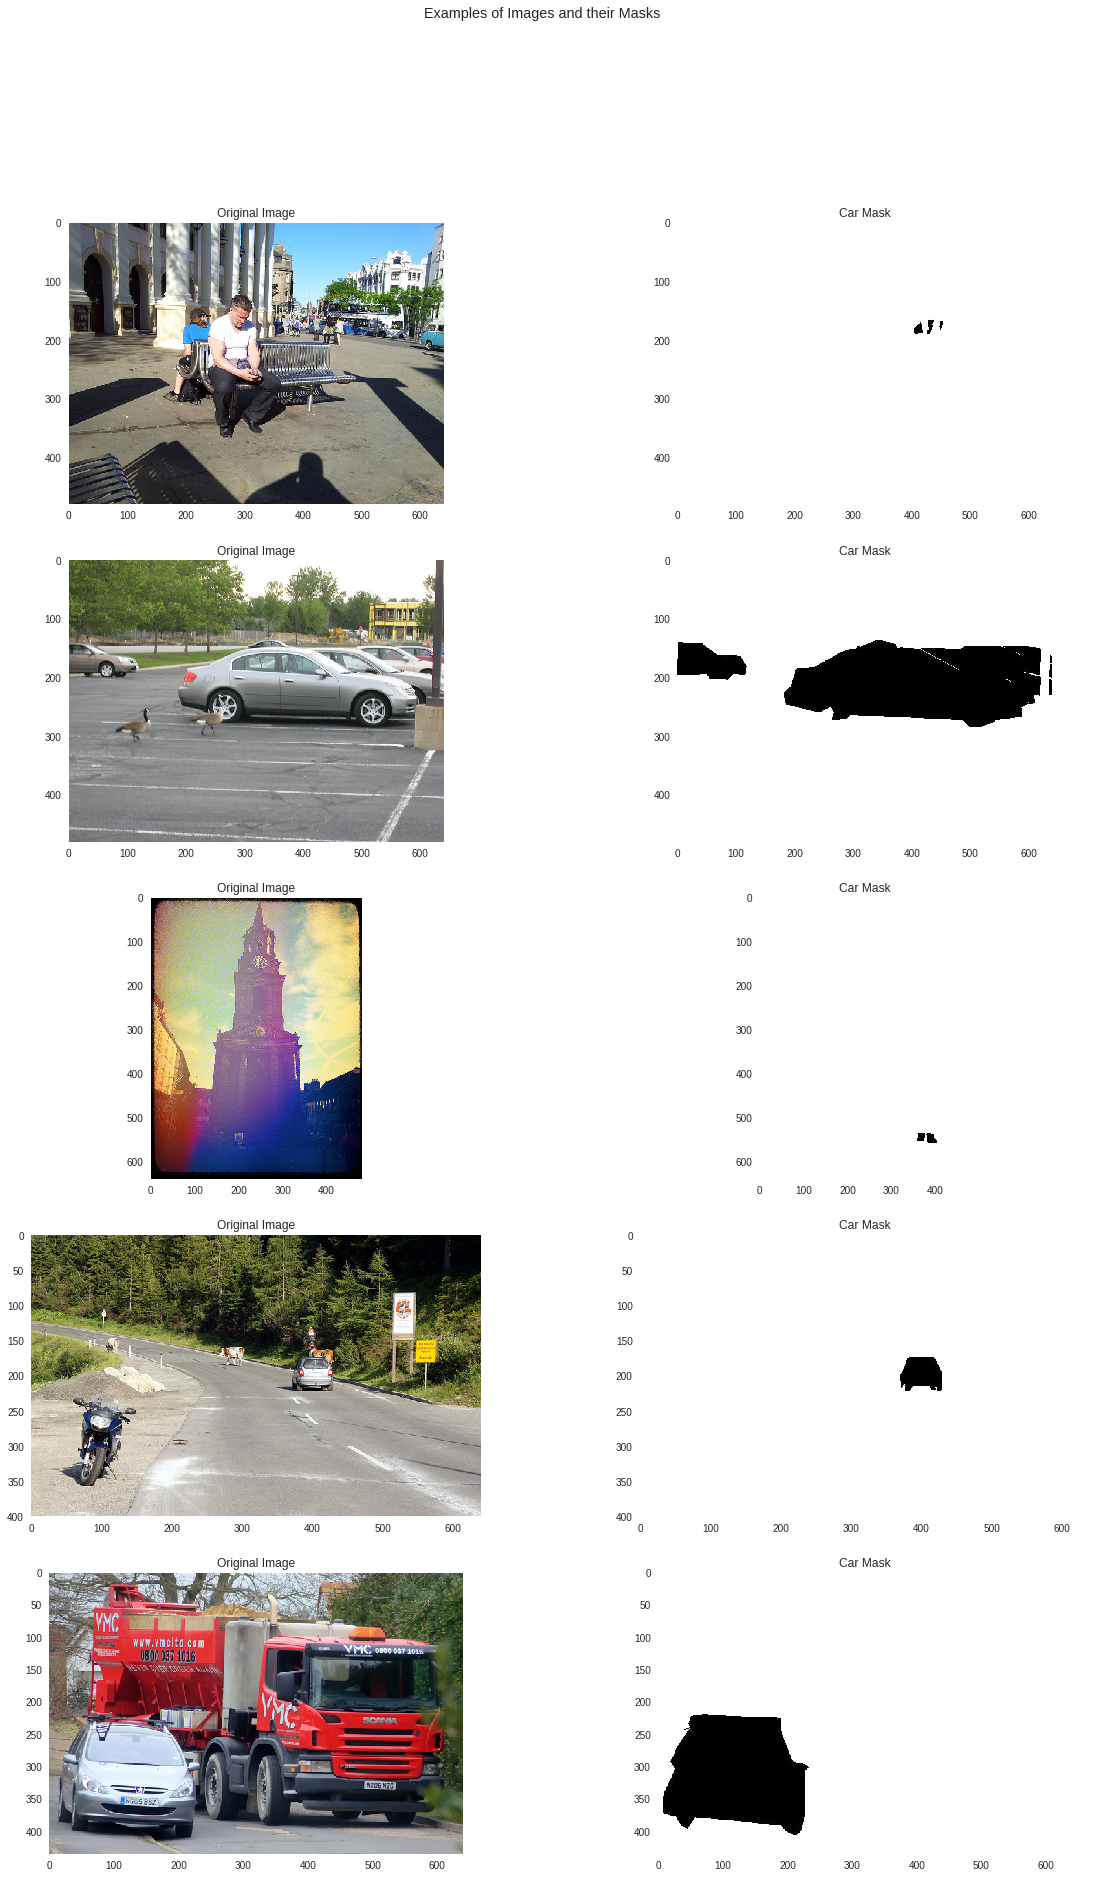

In [14]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(20, 30))
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  x_pathname = x_train_filenames[img_num]
  y_pathname = y_train_filenames[img_num]
  
  plt.subplot(display_num, 2, i + 1)
  plt.imshow(mpimg.imread(x_pathname))
  plt.title("Original Image")
  
  plt.subplot(display_num, 2, i + 2)
  plt.imshow(mpimg.imread(y_pathname))
  plt.title("Car Mask")  
  
plt.suptitle("Examples of Images and their Masks")
plt.show()

In [0]:
img_shape = (256, 256, 3)
batch_size = 16

In [0]:
def _process_pathnames(fname, label_path):
  # We map this function onto each pathname pair  
  img_str = tf.read_file(fname)
  img = tf.image.decode_jpeg(img_str, channels=3)

  label_img_str = tf.read_file(label_path)
  label_img = tf.image.decode_jpeg(label_img_str, channels=0)
  # The label image should only have values of 1 or 0, indicating pixel wise
  # object (car) or not (background). We take the first channel only. 
  label_img = label_img[:, :, 0]
  label_img = tf.expand_dims(label_img, axis=-1)
  return img, label_img

In [0]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
  """This fn will perform the horizontal or vertical shift"""
  if width_shift_range or height_shift_range:
      if width_shift_range:
        width_shift_range = tf.random_uniform([], 
                                              -width_shift_range * img_shape[1],
                                              width_shift_range * img_shape[1])
      if height_shift_range:
        height_shift_range = tf.random_uniform([],
                                               -height_shift_range * img_shape[0],
                                               height_shift_range * img_shape[0])
      # Translate both 
      output_img = tfcontrib.image.translate(output_img,
                                             [width_shift_range, height_shift_range])
      label_img = tfcontrib.image.translate(label_img,
                                             [width_shift_range, height_shift_range])
  return output_img, label_img

In [0]:
def flip_img(horizontal_flip, tr_img, label_img):
  if horizontal_flip:
    flip_prob = tf.random_uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img

In [0]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=False,  # Random left right flip,
             width_shift_range=0,  # Randomly translate the image horizontally
             height_shift_range=0):  # Randomly translate the image vertically 
  if resize is not None:
    # Resize both images with zero padding(black borders) to preserve aspect ratio
    label_img = tf.image.resize_image_with_pad(label_img, *resize)
    img = tf.image.resize_image_with_pad(img, *resize)
  
  if hue_delta:
    img = tf.image.random_hue(img, hue_delta)
  
  img, label_img = flip_img(horizontal_flip, img, label_img)
  img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
  label_img = tf.to_float(label_img) * scale
  img = tf.to_float(img) * scale 
  return img, label_img

In [0]:
def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5, 
                         batch_size=batch_size,
                         shuffle=True):           
  num_x = len(filenames)
  # Create a dataset from the filenames and labels
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  if shuffle:
    dataset = dataset.shuffle(num_x)
  # Map our preprocessing function to every element in our dataset, taking
  # advantage of multithreading
  dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
  if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
    assert batch_size == 1, "Batching images must be of the same size"

  dataset = dataset.map(preproc_fn, num_parallel_calls=threads) 
  dataset = dataset.repeat().batch(batch_size)
  return dataset


In [0]:
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'hue_delta': 0.1,
    'horizontal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

In [0]:
val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

In [0]:
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)

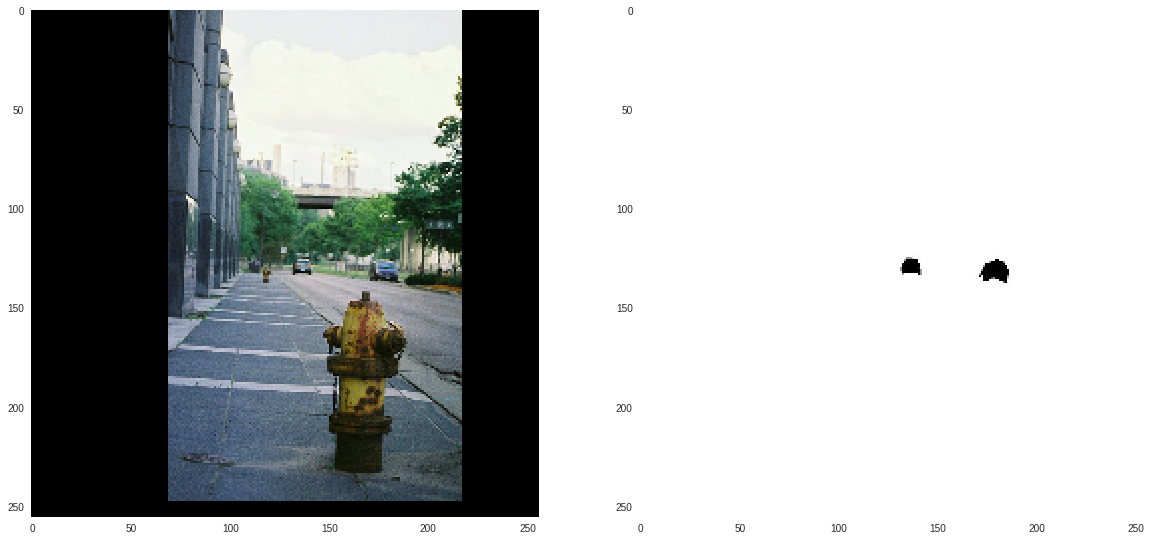

In [34]:
temp_ds = get_baseline_dataset(x_train_filenames, 
                               y_train_filenames,
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=1,
                               shuffle=True)
# Let's examine some of these augmented images
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
with tf.Session() as sess: 
  batch_of_imgs, label = sess.run(next_element)
  plt.figure(figsize=(20, 20))
  img = batch_of_imgs[0]
  plt.subplot(1, 2, 1)
  plt.imshow(img)

  plt.subplot(1, 2, 2)
  plt.imshow(label[0, :, :, 0])
  plt.show()

In [0]:
def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

In [36]:
#Getting a pretrained Resnet50 model for the encoder block
base_model = ResNet50(weights='imagenet',include_top=False,input_shape=img_shape)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step


In [0]:
#We form skip connections from intermediate layers in Resnet encoder block
#to the upsampling layers in decoder block like explained in the Unet paper
encoder0 = base_model.input   #(256,256,3)
encoder1 = base_model.get_layer(name='activation').output  #(128,128,64)
encoder2 = base_model.get_layer(name='activation_9').output  #(64,64,256)
encoder3 = base_model.get_layer(name='activation_21').output   #(32,32,512)
encoder4 = base_model.get_layer(name='activation_39').output   #(16, 16, 1024)
encoder5 = base_model.output   #(8, 8, 2048))

decoder4 = decoder_block(encoder5, encoder4, 1024)
decoder3 = decoder_block(decoder4, encoder3, 512)
decoder2 = decoder_block(decoder3, encoder2, 256)
decoder1 = decoder_block(decoder2, encoder1, 64)
decoder0 = decoder_block(decoder1, encoder0, 32)
outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

In [0]:
model = models.Model(inputs=[base_model.input], outputs=[outputs])

In [0]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [0]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [0]:
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + tf.keras.backend.log(dice_loss(y_true, y_pred))
    return loss

In [0]:
def iou(y_true, y_pred):
    threshold=0.5
    smooth=1e-5
    pre = tf.cast(y_pred > threshold, dtype=tf.float32)
    truth = tf.cast(y_true > threshold, dtype=tf.float32)
    inse = tf.reduce_sum(tf.multiply(pre, truth))
    union = tf.reduce_sum(tf.cast(tf.add(pre, truth) >= 1, dtype=tf.float32))
    batch_iou = (inse + smooth) / (union + smooth)
    iou = tf.reduce_mean(batch_iou)
    return iou

In [49]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss,iou])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
save_model_path = '/tmp/weights.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

In [0]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.2, cooldown=1)

In [0]:
#Training it for 15 epoch. This took around 10 hours on Google Colab. You can skip this and directly use my weights as shown next
epochs = 15
history = model.fit(train_ds, 
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=epochs,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks=[earlyStopping, reduceLROnPlateau, cp])

In [0]:
dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

To skip training and use trained model directly - download model from [Download Link](https://drive.google.com/file/d/1-ArHmzmsorHFS7tj6oQRcrK1A9wi4gzS/view?usp=sharing) and run following

model = models.load_model('<path_to_downloaded_model>', custom_objects={'bce_dice_loss': bce_dice_loss,
                                                           'dice_loss': dice_loss, 'iou':iou})

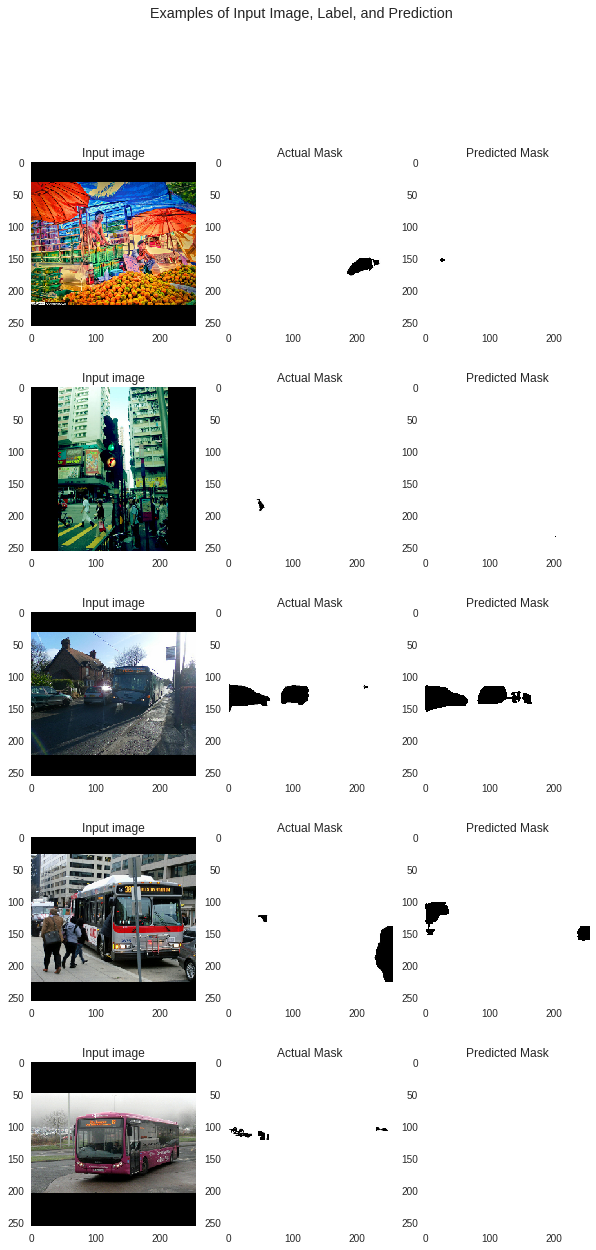

In [72]:
# Let's visualize some of the outputs 
data_aug_iter = val_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

# Running next element in our graph will produce a batch of images
plt.figure(figsize=(10, 20))

for i in range(5):
  batch_of_imgs, label = tf.keras.backend.get_session().run(next_element)
  img = batch_of_imgs[0]
  predicted_label = model.predict(batch_of_imgs)[0]

  plt.subplot(5, 3, 3 * i + 1)
  plt.imshow(img)
  plt.title("Input image")
  
  plt.subplot(5, 3, 3 * i + 2)
  plt.imshow(label[0, :, :, 0])
  plt.title("Actual Mask")
  plt.subplot(5, 3, 3 * i + 3)
  plt.imshow(predicted_label[:, :, 0]>0.5)
  plt.title("Predicted Mask")

plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.show()

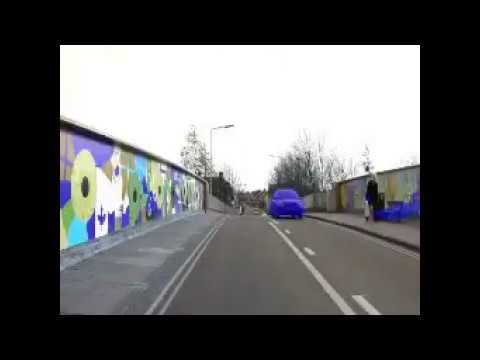

In [27]:
#Also, I have run the model on CamVid dataset and created the following Segmentation video.
from IPython.display import YouTubeVideo
vid = YouTubeVideo("350qCfVKBwg")
display(vid)

CamVid dataset was used in Segnet. It has image frames annotated from road videos. To generate a video like above use following code

In [73]:
#Downloading CamVid dataset
!wget 'https://github.com/alexgkendall/SegNet-Tutorial/archive/master.zip'
!unzip master.zip

--2019-01-09 11:44:49--  https://github.com/alexgkendall/SegNet-Tutorial/archive/master.zip
Resolving github.com (github.com)... 192.30.255.113, 192.30.255.112
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/alexgkendall/SegNet-Tutorial/zip/master [following]
--2019-01-09 11:44:49--  https://codeload.github.com/alexgkendall/SegNet-Tutorial/zip/master
Resolving codeload.github.com (codeload.github.com)... 192.30.255.120, 192.30.255.121
Connecting to codeload.github.com (codeload.github.com)|192.30.255.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [       <=>          ] 178.41M  19.8MB/s    in 8.3s    

2019-01-09 11:44:58 (21.5 MB/s) - ‘master.zip’ saved [187075221]

Archive:  master.zip
bb68b64e72cb004b3ed927fee0f5624dd8097498
   creating: SegNet-Tutorial-master/
  i

In [0]:
os.remove('master.zip')
dataset_path = os.path.abspath('.') + '/' + 'SegNet-Tutorial-master/CamVid'

In [0]:
val_files = os.listdir(dataset_path + '/test')
val_files.sort()
filenames = []
for filename in val_files:
  if filename.endswith(".png"):
    filenames.append(dataset_path + '/test/' + filename)
predict_batch_size = 16
filenames = [filenames[i:min(i+predict_batch_size,len(filenames))] for i in range(0,len(filenames),predict_batch_size)]

In [0]:
def mask_color_img(img, mask, color=[0, 255, 255], alpha=0.3):
    '''
    img: cv2 image
    mask: bool or np.where
    color: BGR triplet [_, _, _]. Default: [0, 255, 255] is yellow.
    alpha: float [0, 1]. 
    
    Ref: http://www.pyimagesearch.com/2016/03/07/transparent-overlays-with-opencv/
    '''
    out = img.copy()
    img_layer = img.copy()
    img_layer[mask] = color
    out = cv2.addWeighted(img_layer, alpha, out, 1 - alpha, 0, out)
    return(out)

def preprocess_frame(frame):
  processed_frame = tf.image.resize_image_with_pad(frame, img_shape[0], img_shape[1])
  processed_frame = tf.to_float(processed_frame) * (1/255.0) 
  processed_frame = tf.keras.backend.get_session().run(processed_frame)
  return processed_frame
  
def resize_frame(frame):
  frame_resized = tf.image.resize_image_with_pad(frame, img_shape[0], img_shape[1])
  frame_resized = tf.keras.backend.get_session().run(frame_resized)
  return frame_resized

def predict_masks(filenames):
  frames = [Image.open(filename) for filename in filenames]
  resized_frames = [resize_frame(frame) for frame in frames]
  processed_frames = [preprocess_frame(frame) for frame in frames]

  preds = model.predict(np.stack(processed_frames,axis=0))
  masks = []
  for i in range(preds.shape[0]):
    mask = mask_color_img(resized_frames[i], preds[i,:, :, 0]>0.5, [255, 0, 0], alpha=.5)
    masks.append(mask.astype('uint8'))
  return masks

In [22]:
out = cv2.VideoWriter('camvid_test.avi', cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'),
                      10, (img_shape[0], img_shape[1]))
i = 0
for batch in filenames:
  masks = predict_masks(batch)
  for mask in masks:
    out.write(mask)
  i+=1
  print(f'{i}/{len(filenames)} batches completed...')

out.release()

1/15 batches completed...
2/15 batches completed...
3/15 batches completed...
4/15 batches completed...
5/15 batches completed...
6/15 batches completed...
7/15 batches completed...
8/15 batches completed...
9/15 batches completed...
10/15 batches completed...
11/15 batches completed...
12/15 batches completed...
13/15 batches completed...
14/15 batches completed...
15/15 batches completed...
